In [1]:
%matplotlib inline

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"



# hyperparameter optimization with Model class for NNs


In [1]:

from ai4water.functional import Model
from ai4water.datasets import MtropicsLaos
from ai4water.utils.utils import get_version_info
from ai4water.hyperopt import Categorical, Real, Integer


D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:

for k,v in get_version_info().items():
    print(f"{k} version: {v}")
    

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os version: nt
ai4water version: 1.06
lightgbm version: 3.3.1
tcn version: 3.4.0
catboost version: 0.26
xgboost version: 1.5.0
easy_mpl version: 0.21.3
SeqMetrics version: 1.3.3
tensorflow version: 2.7.0
keras.api._v2.keras version: 2.7.0
numpy version: 1.21.0
pandas version: 1.3.4
matplotlib version: 3.4.3
h5py version: 3.5.0
sklearn version: 1.0.1
shapefile version: 2.3.0
xarray version: 0.20.1
netCDF4 version: 1.5.7
optuna version: 2.10.1
skopt version: 0.9.0
hyperopt version: 0.2.7
plotly version: 5.3.1
lime version: NotDefined
seaborn version: 0.11.2


In [3]:
# prepare the data

dataset = MtropicsLaos(path="F:\\data\\MtropicsLaos")
data = dataset.make_regression(lookback_steps=1)
print(data.shape)


    Not downloading the data since the directory 
    F:\data\MtropicsLaos already exists.
    Use overwrite=True to remove previously saved files and download again


Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


(258, 9)


In [4]:
input_features = data.columns.tolist()[0:-1]
print(input_features)

['air_temp', 'rel_hum', 'wind_speed', 'sol_rad', 'water_level', 'pcp', 'susp_pm', 'Ecoli_source']


In [5]:
output_features = data.columns.tolist()[-1:]
print(output_features)

['Ecoli_mpn100']


build the model



In [8]:
lookback = 14

model = Model(
    model = {"layers": {
        "Input": {"shape": (lookback, len(input_features))},
        "LSTM": {"units": Integer(10, 30, name="units", num_samples=10),
                 "activation": Categorical(["relu", "elu", "tanh"], name="activation")},
        "Dense": 1
    }},
    lr=Real(0.00001, 0.01, name="lr", num_samples=10),
    batch_size=Categorical([4, 8, 12, 16, 24], name="batch_size"),
    epochs=500,
    ts_args={"lookback": lookback},
    input_features=input_features,
    output_features=output_features,
    x_transformation="zscore",
    y_transformation={"method": "log", "replace_zeros": True, "treat_negatives": True},
    val_metric="rmse"
)


            building DL model for  
            regression problem using Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 14, 8)]           0         
                                                                 
 LSTM (LSTM)                 (None, 15)                1440      
                                                                 
 Dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1,456
Trainable params: 1,456
Non-trainable params: 0
_________________________________________________________________


***** Training *****
input_x shape:  (136, 14, 8)
target shape:  (136, 1)
***** Validation *****
input_x shape:  (35, 14, 8)
target shape:  (35, 1)
***** Validation *****
input_x shape:  (35, 14, 8)
target shape:  (35, 1)


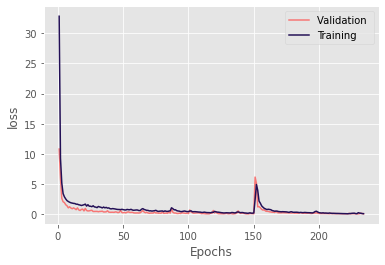

********** Successfully loaded weights from weights_134_0.08508.hdf5 file **********


In [8]:
_ = model.fit_on_all_training_data(data=data, verbose=0)

In [9]:
model.evaluate_on_training_data(data=data, metrics=['r2', 'nse', 'rmse'])

***** Training *****
input_x shape:  (136, 14, 8)
target shape:  (136, 1)
5/5 [==============================] - 0s 2ms/step



            argument test is deprecated and will be removed in future. Please 
            use 'predict_on_test_data' method instead.


{'r2': 0.9383992599582605,
 'nse': 0.9351325536411559,
 'rmse': 2076.4358887285684}

In [10]:
model.evaluate_on_test_data(data=data, metrics=['r2', 'nse', 'rmse'])


            argument test is deprecated and will be removed in future. Please 
            use 'predict_on_test_data' method instead.


***** Test *****
input_x shape:  (74, 14, 8)
target shape:  (74, 1)
3/3 [==============================] - 0s 2ms/step


{'r2': 0.004700969723135662,
 'nse': -0.032661562876391104,
 'rmse': 27295.650642547433}

In [11]:
model.val_metric

'rmse'

In [9]:
optimizer = model.optimize_hyperparameters(
    data=data,
    algorithm="random",
    num_iterations=100,
    process_results=False,
    refit=False,
)

Iteration No.   Validation Score    
total number of iterations: 100
0               17828.95533          17828.95533         
1               16986.79110          16986.79110         
2               22394144395.06774    22394144395.06774   
3               199641.76044         199641.76044        
4               133568722174052.40625 133568722174052.40625
5               18900.29079          18900.29079         
6               42857348.18667       42857348.18667      
7               18069.27824          18069.27824         
8               11462458.58969       11462458.58969      
9               18197.39146          18197.39146         
10              401327.35925         401327.35925        
11              100104.81291         100104.81291        
12              23519115.01190       23519115.01190      
13              23852.58460          23852.58460         
14              519146.96604         519146.96604        
15              23264.56258          23264.56258         
1

0 is not equal to 100 so can not perform ranking


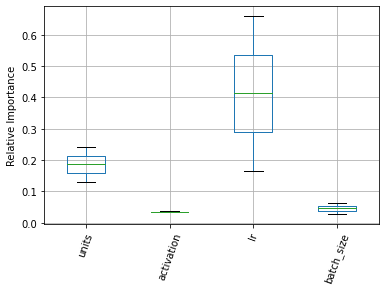

In [10]:
_ = optimizer.plot_importance()

In [11]:
optimizer.best_paras()

{'units': 25, 'activation': 'tanh', 'lr': 0.01, 'batch_size': 8}

In [12]:
optimizer.best_iter()

87

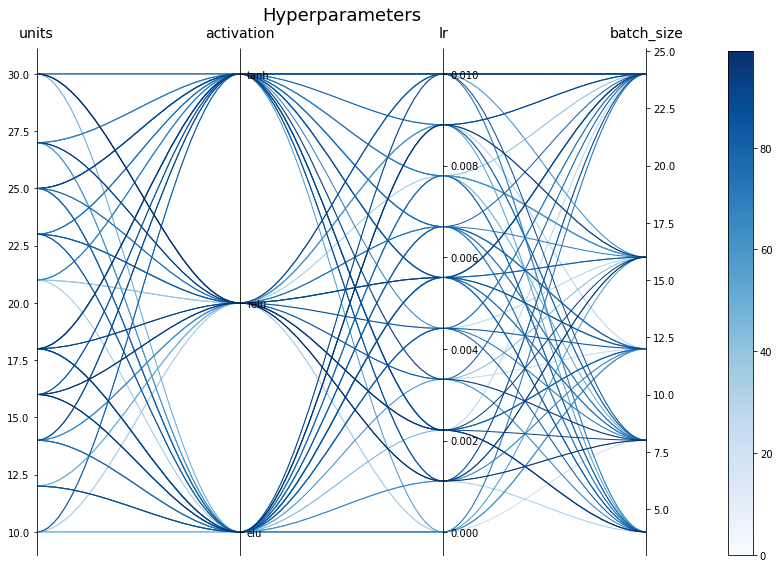

In [13]:
optimizer._plot_parallel_coords(figsize=(12, 8))

In [14]:
model = Model(
    model = {"layers": {
        "Input": {"shape": (lookback, len(input_features))},
        "LSTM": {"units": optimizer.best_paras()['units'],
                 "activation": optimizer.best_paras()['activation']},
        "Dense": 1
    }},
    lr=optimizer.best_paras()['lr'],
    batch_size=optimizer.best_paras()['batch_size'],
    epochs=1000,
    ts_args={"lookback": lookback},
    input_features=input_features,
    output_features=output_features,
    x_transformation="zscore",
    y_transformation={"method": "log", "replace_zeros": True, "treat_negatives": True},
)


            building DL model for  
            regression problem using Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 14, 8)]           0         
                                                                 
 LSTM (LSTM)                 (None, 25)                3400      
                                                                 
 Dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 3,426
Trainable params: 3,426
Non-trainable params: 0
_________________________________________________________________


***** Training *****
input_x shape:  (136, 14, 8)
target shape:  (136, 1)
***** Validation *****
input_x shape:  (35, 14, 8)
target shape:  (35, 1)
***** Validation *****
input_x shape:  (35, 14, 8)
target shape:  (35, 1)


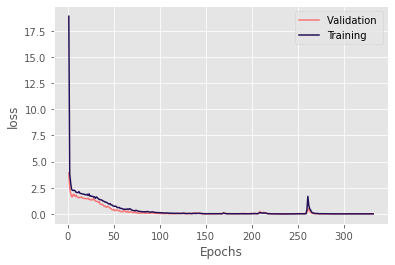

********** Successfully loaded weights from weights_237_0.00062.hdf5 file **********


In [15]:
_ = model.fit_on_all_training_data(data=data, verbose=0)

In [16]:
print(model.evaluate_on_test_data(data=data, metrics=['r2', 'nse', 'rmse']))

***** Test *****
input_x shape:  (74, 14, 8)
target shape:  (74, 1)



            argument test is deprecated and will be removed in future. Please 
            use 'predict_on_test_data' method instead.


3/3 [==============================] - 0s 2ms/step
{'r2': 0.0013408165145923254, 'nse': -0.028649883432676937, 'rmse': 27242.579613538805}
